# Spaceship Titanic 사고자 예측

## 목표: 다른 시공간으로 전송된 승객 예측
- 지구, 화성, 유로파 -> 다른 행성으로 항해: TRAPPIST-1e, PSO J318.5-22, 55 Cancri e 	
- 우주먼지 입자 사이에 숨어있는 '시공간입자'와 충돌
- 반 이상의 승객들이 다른 시공간으로 전송됨

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

# 1. 데이터 가져오기

In [86]:
# from check import 

import numpy as np
import pandas as pd

train = pd.read_csv('./spaceship-titanic/train.csv')
test = pd.read_csv('./spaceship-titanic/test.csv')
submission = pd.read_csv('./spaceship-titanic/sample_submission.csv')
train.shape, test.shape, submission.shape # check shape


# Create check columns
check = train.copy()
check['g_Id'] = check['PassengerId'].apply(lambda x:x.split('_')[0]).astype(int)
check['groupSize'] = check['g_Id'].map(lambda x: check['g_Id'].value_counts()[x])
check['solo'] = check['groupSize']==1
check['C_deck'] = check['Cabin'].str.split('/').str[0]
check['C_num'] = check['Cabin'].str.split('/').str[1].astype(float)
check['C_side'] = check['Cabin'].str.split('/').str[2]

# 2. 데이터 훑어 보기
- 약 8700개 행, 14개 열
- 데이터의 Null 값이 많음: 모든 행에 약 100 - 200 개 데이터 없음

In [87]:
train.shape, test.shape

((8693, 14), (4277, 13))

In [84]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [88]:
check.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,g_Id,groupSize,solo,C_deck,C_num,C_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,True,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1,True,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,2,False,A,0.0,S


In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [94]:
check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  g_Id          8693 non-null   int32  
 15  groupSize     8693 non-null   int64  
 16  solo          8693 non-null   bool   
 17  C_deck        8494 non-null   object 
 18  C_num         8494 non-null 

- 항목별 null 값 확인 -> 데이터에 전반적으로 분포되어 있어 null 값 예측 필요.

In [105]:
check.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
g_Id              0
groupSize         0
solo              0
C_deck          199
C_num           199
C_side          199
total_servs     908
dtype: int64

# 3. 해결 절차
### 1) 시각화 및 데이터 간의 관계를 파악, 'Transported'  
### 2) 모델 훈련 (Logistic Regression, KNearestNeighbors, Decision Tree, RandomForest, SVM) 
### 3) 결과 예측

# 4. 시각화 및 데이터 간의 관계를 파악, 'Transported'
- 나이, deck, side, 출발지, 도착지, 동결수면, 소비 등

Text(0.5, 0, 'Age (years)')

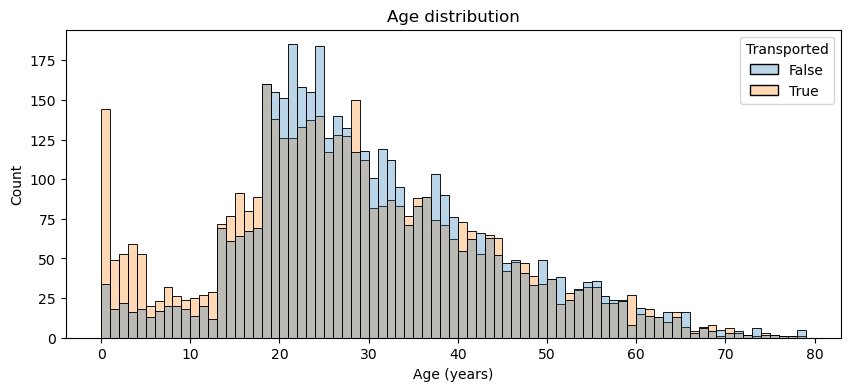

In [89]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=check, x='Age', hue='Transported', binwidth=1, kde=False, alpha = 0.3)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

Text(0.5, 0, 'Cabin_deck')

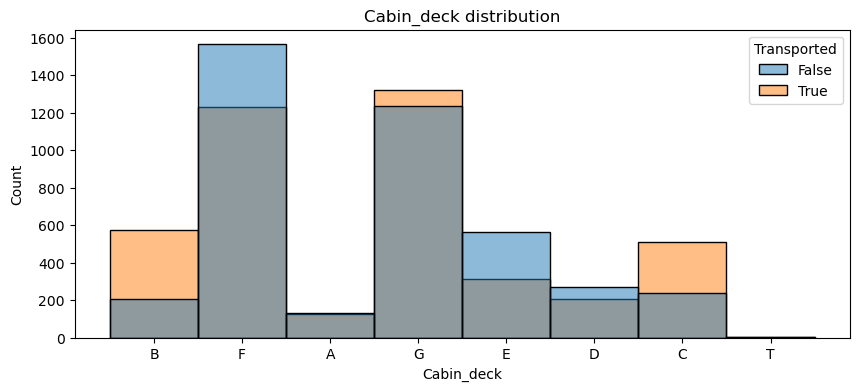

In [91]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=check, x='C_deck', hue='Transported', binwidth=1, kde=False)

# Aesthetics
plt.title('Cabin_deck distribution')
plt.xlabel('Cabin_deck')

Text(0.5, 0, 'Cabin_side')

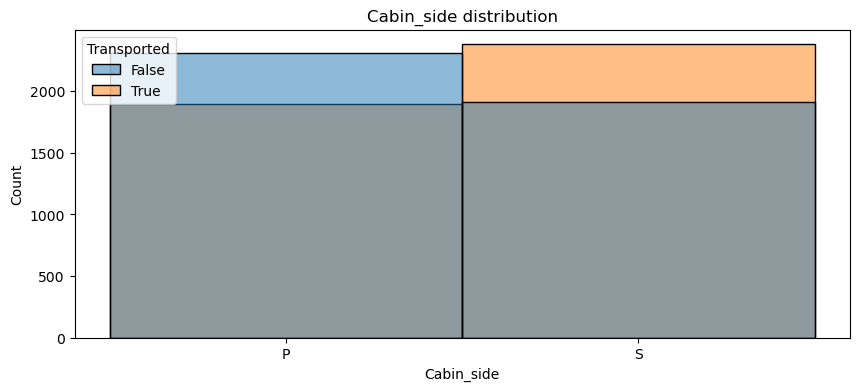

In [92]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=check, x='C_side', hue='Transported', binwidth=1, kde=False)

# Aesthetics
plt.title('Cabin_side distribution')
plt.xlabel('Cabin_side')

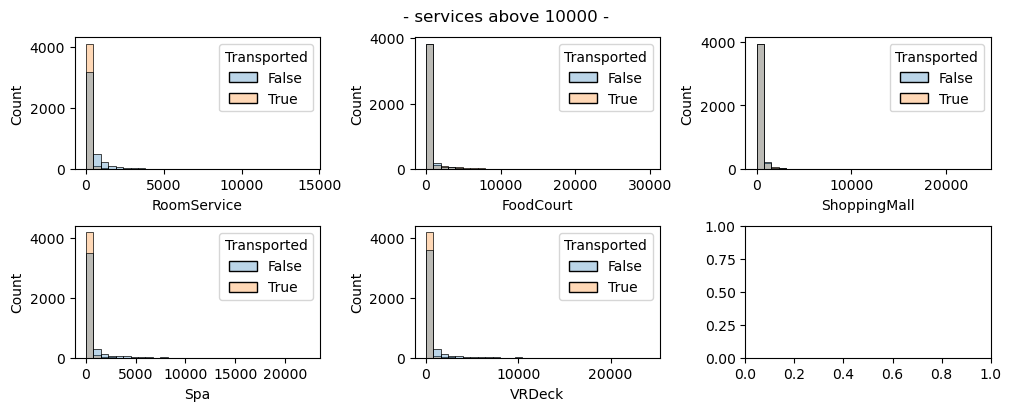

In [96]:
# 0을 포함한 데이터#
fig, ax = plt.subplots(2,3, figsize=(10,4), constrained_layout=True)
ax = ax.flatten()
services_li = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for i, col in enumerate(services_li):
    sns.histplot(data=check, x=col, hue='Transported', ax=ax[i], bins=30, alpha=0.3)
fig.suptitle('- services above 10000 -')
plt.show()

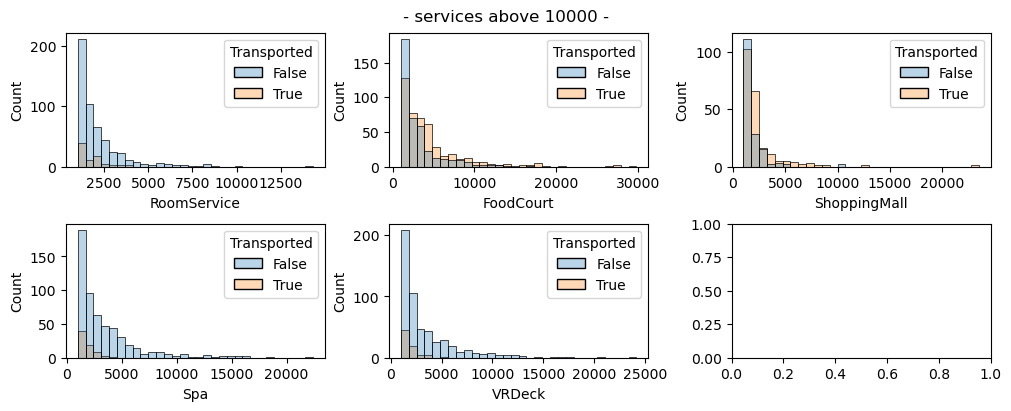

In [95]:
fig, ax = plt.subplots(2,3, figsize=(10,4), constrained_layout=True)
ax = ax.flatten()
services_li = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for i, col in enumerate(services_li):
    sns.histplot(data=check[check[col]>1000], x=col, hue='Transported', ax=ax[i], bins=30, alpha=0.3)
fig.suptitle('- services above 10000 -')
plt.show()

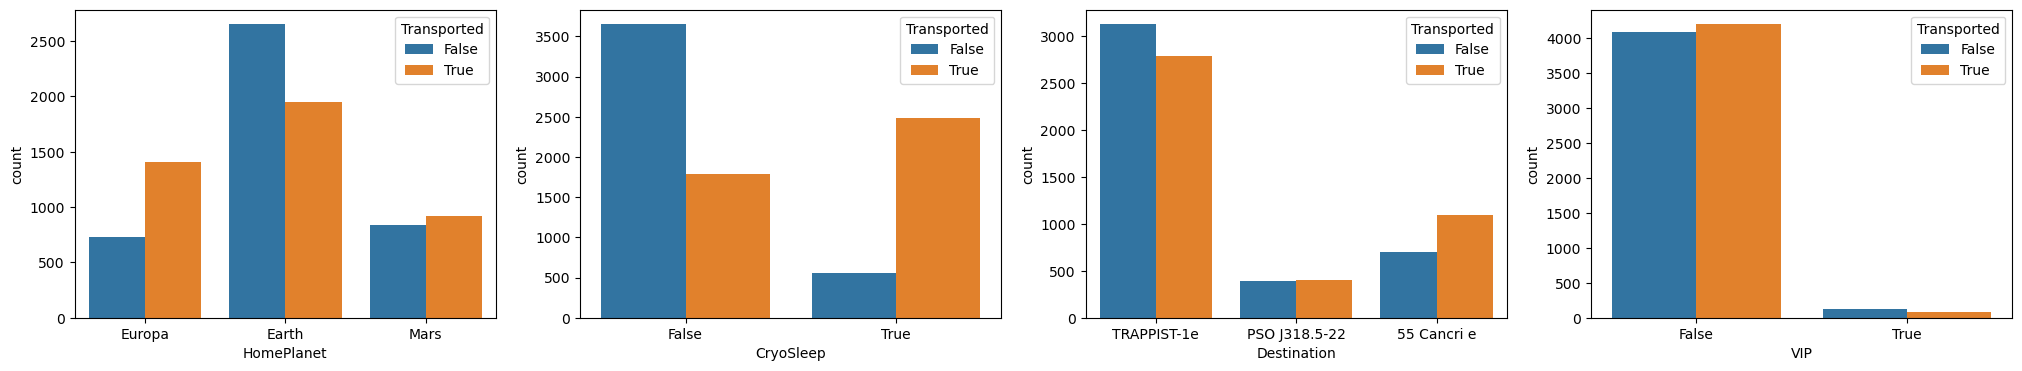

In [97]:
columns_1 = ['HomePlanet', 'CryoSleep', 'Destination','VIP']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))
for i, column in enumerate(columns_1):
    sns.countplot(data=check, x=column, hue='Transported', ax=axes[i])
plt.show()

- CryoSleep Null 값 예측

Text(0.5, 0, 'Cabin_deck')

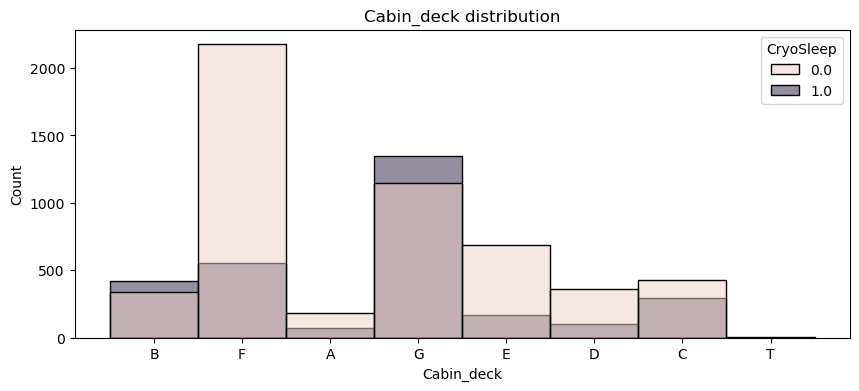

In [99]:
# F, E, D Deck의 경우 CryoSleep == False인 경향이 높음
plt.figure(figsize=(10,4))
sns.histplot(data=check, x='C_deck', hue='CryoSleep', binwidth=1, kde=False)
plt.title('Cabin_deck distribution')
plt.xlabel('Cabin_deck')

- VIP: spending 기준 (돈을 많이 씀 -> VIP)

<AxesSubplot:xlabel='Transported', ylabel='total_servs'>

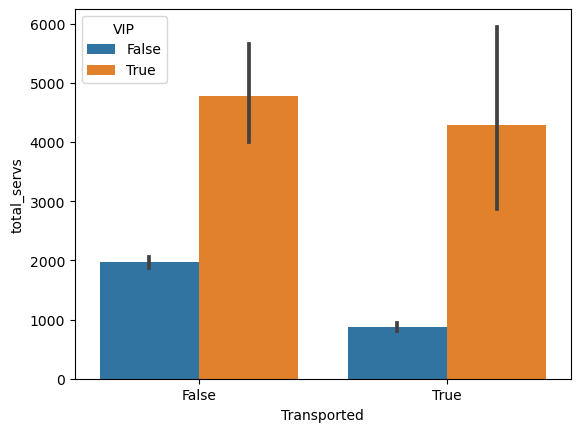

In [104]:
check['total_servs'] = check['RoomService']+check['FoodCourt']+check['ShoppingMall']+check['Spa']+check['VRDeck']
sns.barplot(data=check, x='Transported', y='total_servs', hue='VIP')

# 5. 모델 훈련
- 1) Null 값 채우기 -> 실행 불가
- 2) 최빈값, 중앙값

## 5.1 데이터 불러오기

In [107]:
# from check import 

import numpy as np
import pandas as pd

train = pd.read_csv('./spaceship-titanic/train.csv')
test = pd.read_csv('./spaceship-titanic/test.csv')
submission = pd.read_csv('./spaceship-titanic/sample_submission.csv')
train.shape, test.shape, submission.shape # check shape


# Create check columns
check = pd.concat([train, test], axis=0)
check['g_Id'] = check['PassengerId'].apply(lambda x:x.split('_')[0]).astype(int)
check['groupSize'] = check['g_Id'].map(lambda x: check['g_Id'].value_counts()[x])
check['solo'] = check['groupSize']==1
check['C_deck'] = check['Cabin'].str.split('/').str[0]
check['C_num'] = check['Cabin'].str.split('/').str[1].astype(float)
check['C_side'] = check['Cabin'].str.split('/').str[2]

## 5.2 데이터 준비
- Pipeline 활용

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

### 5.2.1 Train data 컬럼 추가

In [26]:
train['g_Id'] = train['PassengerId'].apply(lambda x:x.split('_')[0]).astype(int)
train['groupSize'] = train['g_Id'].map(lambda x: check['g_Id'].value_counts()[x])
train['solo'] = train['groupSize']==1
train['C_deck'] = train['Cabin'].str.split('/').str[0]
train['C_num'] = train['Cabin'].str.split('/').str[1].astype(float)
train['C_side'] = train['Cabin'].str.split('/').str[2]

### 5.2.2 전처리: Pipeline

- 범주형 데이터 전처리

In [24]:
cat_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')), # 누락된 데이터를 채워주는 변환기
                ('oh_encoder', OneHotEncoder(sparse=False)) # Onehot Encoding 해주는 변환기, sklearn 1.2 에서는 sparse_output
            ])

- 수치형 데이터 전처리

In [25]:
num_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='median')), # 누락된 데이터를 채워주는 변환기
                ('std_scaler', StandardScaler()) # 평균을 0, 표준편차1로 만들어주는 변환기기
            ])

- 범주형 데이터와 수치형 데이터를 연결

In [28]:
from sklearn.compose import ColumnTransformer

# num_attribs = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','g_Id','groupSize','C_num','total_servs']
num_attribs = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck', 'groupSize', 'solo','C_num']
cat_attribs = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP','C_deck','C_side'] #, 'Age_cat']
# cat_attribs = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP','solo','C_deck','C_side','Age_cat','FName'] #, 'Age_cat']

full_pipeline = ColumnTransformer([
#                     ('num', SimpleImputer(strategy='most_frequent'), num_attribs), # 수치형
                    ('num', num_pipeline, num_attribs), # 수치형
                    ('cat', cat_pipeline, cat_attribs)  # 범주형
            ])
X_train = train.drop(columns=['Transported'])
X_train_prepraed = full_pipeline.fit_transform(X_train)


y_train = train['Transported'].copy()
X_test = test.copy()

In [29]:
X_train_prepraed.shape

(8693, 29)

In [30]:
X_train.shape 

(8693, 19)

## 5.3 모델 선택과 훈련
- Logistic Regression
- KNearestNeighbors
- Decision Tree
- RandomForest
- SVM

- Logistic Regression

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(max_iter=1000, random_state=42) # C가 작을 수록 규제가 강해짐
log_clf_scores = cross_val_score(log_clf, X_train_prepraed, y_train, scoring="accuracy", cv=3)
log_clf_scores

array([0.77950311, 0.7915804 , 0.76561961])

- KNearestNeighbors

In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf_scores = cross_val_score(knn_clf, X_train_prepraed, y_train, scoring="accuracy", cv=3)
knn_clf_scores

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

array([0.74982747, 0.76397516, 0.75388333])

- Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf_scores = cross_val_score(tree_clf, X_train_prepraed, y_train, scoring="accuracy", cv=3)
tree_clf_scores

array([0.67805383, 0.74258109, 0.71971004])

- RandomForest

In [37]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rnd_clf_scores = cross_val_score(rnd_clf, X_train_prepraed, y_train, scoring="accuracy", cv=3)
rnd_clf_scores

array([0.75569358, 0.7926156 , 0.78322402])

- SVM

In [38]:
from sklearn.svm import LinearSVC, SVC

# 1. LinearSVC
linear_svc = LinearSVC(random_state = 42)
linear_svc_scores = cross_val_score(linear_svc, X_train_prepraed, y_train, scoring="accuracy", cv=3)
print(linear_svc_scores)

# 2. SCV
linear_kernel_svc = SVC(kernel='linear')
linear_kernel_svc_scores = cross_val_score(linear_kernel_svc, X_train_prepraed, y_train, scoring="accuracy", cv=3)
print(linear_kernel_svc_scores)

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.77812284 0.78709455 0.76492924]
[0.78502415 0.78295376 0.79461512]


## 5.4 하이퍼 파라미터 튜닝
- LogisticRegression
- KNeighborsClassifier
- Decision Tree (실패)
- RandomForest
- SVM

In [39]:
from sklearn.model_selection import GridSearchCV

- LogisticRegression

In [41]:
param_grid = {'C':[0.1, 0.2, 0.5, 1, 10], 'max_iter':[1000, 2000]} # 5x2 = 10개의 조합

grid_search = GridSearchCV(log_clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1) # 5x2x5 = 50번의 학습과 검증
grid_search.fit(X_train_prepraed, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.5, 1, 10], 'max_iter': [1000, 2000]},
             scoring='accuracy')

In [42]:
grid_search.best_params_

{'C': 1, 'max_iter': 1000}

In [43]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.7837344187465383 {'C': 0.1, 'max_iter': 1000}
0.7837344187465383 {'C': 0.1, 'max_iter': 2000}
0.7841939238653486 {'C': 0.2, 'max_iter': 1000}
0.7841939238653486 {'C': 0.2, 'max_iter': 2000}
0.7853445395055951 {'C': 0.5, 'max_iter': 1000}
0.7853445395055951 {'C': 0.5, 'max_iter': 2000}
0.7859197811527464 {'C': 1, 'max_iter': 1000}
0.7859197811527464 {'C': 1, 'max_iter': 2000}
0.7852293323610319 {'C': 10, 'max_iter': 1000}
0.7852293323610319 {'C': 10, 'max_iter': 2000}


In [44]:
lr_final_model = grid_search.best_estimator_
lr_final_model.fit(X_train_prepraed, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=42)

- KNeighborsClassifier

In [45]:
param_grid = {'n_neighbors':[3, 5, 7, 9, 11]}

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1) # 24 * 5 = 100번의 학습과 검증
grid_search.fit(X_train_prepraed, y_train)  

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11]}, scoring='accuracy')

In [46]:
grid_search.best_params_

{'n_neighbors': 11}

In [47]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.7613029722913913 {'n_neighbors': 3}
0.7693559583136744 {'n_neighbors': 5}
0.7722307769170145 {'n_neighbors': 7}
0.7726920025331013 {'n_neighbors': 9}
0.7740727015976141 {'n_neighbors': 11}


- Decision Tree

In [56]:
param_grid = {'max_depth':[3, 5, 7, 9, 11]}

grid_search = GridSearchCV(tree_clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1) 
grid_search.fit(X_train_prepraed, y_train) 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11]}, scoring='accuracy')

In [57]:
grid_search.best_params_

{'max_depth': 5}

In [58]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.720121480342326 {'max_depth': 3}
0.7632627510354416 {'max_depth': 5}
0.7582018421231995 {'max_depth': 7}
0.7542887695863726 {'max_depth': 9}
0.7486516926053689 {'max_depth': 11}


In [59]:
tree_final_model = grid_search.best_estimator_
tree_final_model.fit(X_train_prepraed, y_train)  

DecisionTreeClassifier(max_depth=5)

In [60]:
#num_attribs = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','g_Id','groupSize','C_num','total_servs']
#cat_attribs = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP','solo','C_deck','C_side','Age_cat','FName'] #, 'Age_cat']

num_attribs = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']#, 'groupSize', 'solo','C_num']
cat_attribs = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']#,'C_deck','C_side'] #, 'Age_cat']

all_attribs = num_attribs + cat_attribs
target_names = ['Transported']

IndexError: list index out of range

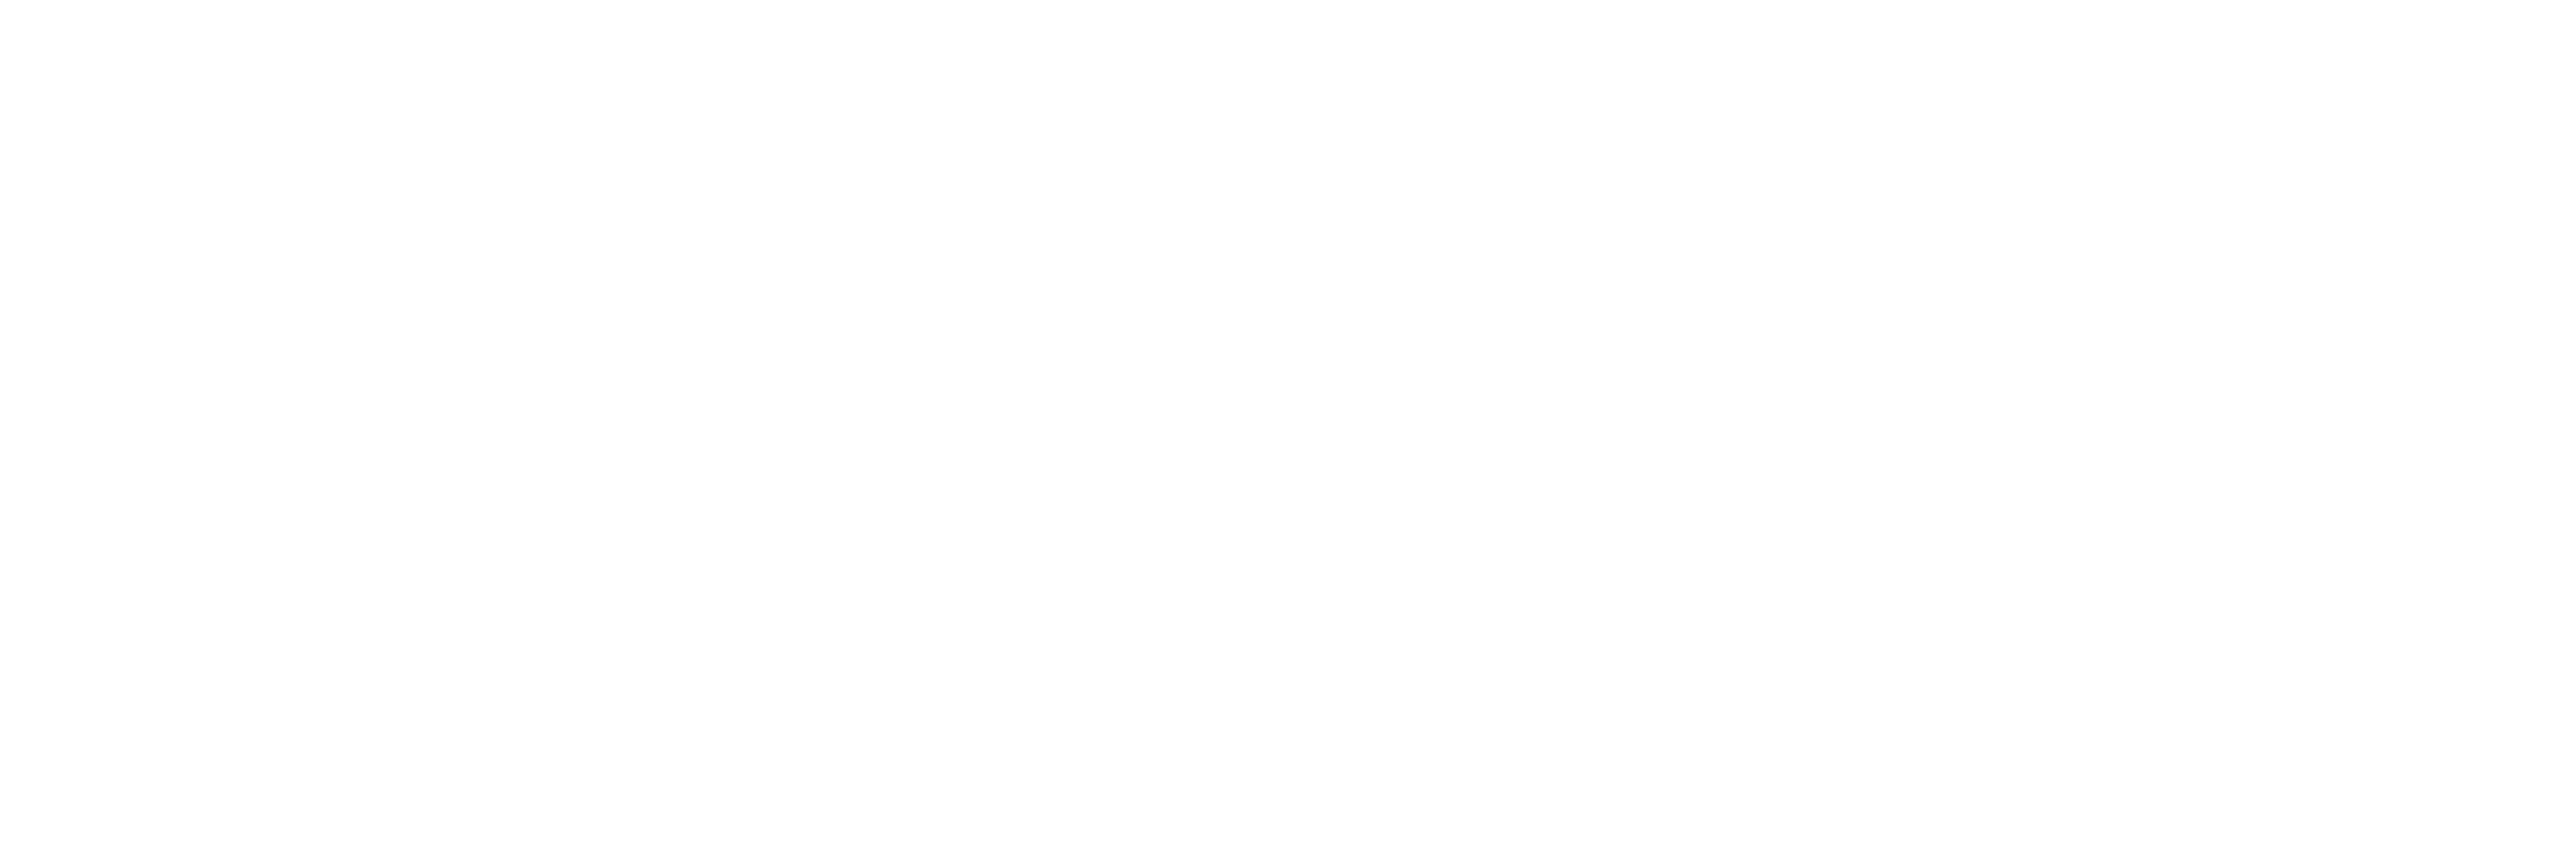

In [61]:
from sklearn import tree
plt.figure(figsize=(150, 50))
res = tree.plot_tree(tree_final_model,
                feature_names = all_attribs,
                class_names = target_names,
                rounded = True,
                filled = True,
                fontsize=25)

In [62]:
sorted(zip(tree_final_model.feature_importances_, all_attribs), reverse=True)

[(0.11366582378096216, 'Spa'),
 (0.10175580647746003, 'VRDeck'),
 (0.07521897839206132, 'FoodCourt'),
 (0.06826177892361006, 'VIP'),
 (0.06535371003245144, 'RoomService'),
 (0.016750830836875723, 'Destination'),
 (0.0049361464443855715, 'ShoppingMall'),
 (0.002164067716725572, 'Age'),
 (2.9737414197425693e-05, 'HomePlanet'),
 (0.0, 'CryoSleep')]

- RandomForest

In [63]:
param_grid = {'n_estimators':[100, 200, 300], 'max_depth':[5, 7, 9, 11]}

grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1) 
grid_search.fit(X_train_prepraed, y_train)  

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9, 11],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [64]:
print(grid_search.best_params_)
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

rf_final_model = grid_search.best_estimator_
rf_final_model.fit(X_train_prepraed, y_train) 

{'max_depth': 11, 'n_estimators': 200}
0.7648705557404722 {'max_depth': 5, 'n_estimators': 100}
0.7648711512972218 {'max_depth': 5, 'n_estimators': 200}
0.763375708298951 {'max_depth': 5, 'n_estimators': 300}
0.7891430004546083 {'max_depth': 7, 'n_estimators': 100}
0.7900634003246446 {'max_depth': 7, 'n_estimators': 200}
0.7902936822678271 {'max_depth': 7, 'n_estimators': 300}
0.7945500601843183 {'max_depth': 9, 'n_estimators': 100}
0.7948955492720643 {'max_depth': 9, 'n_estimators': 200}
0.795355649947624 {'max_depth': 9, 'n_estimators': 300}
0.7946656643667147 {'max_depth': 11, 'n_estimators': 100}
0.7959312886326083 {'max_depth': 11, 'n_estimators': 200}
0.794550655741068 {'max_depth': 11, 'n_estimators': 300}


RandomForestClassifier(max_depth=11, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [65]:
sorted(zip(rf_final_model.feature_importances_, all_attribs), reverse=True)

[(0.10878237657874387, 'Spa'),
 (0.09713026622082942, 'VRDeck'),
 (0.0958554282375232, 'RoomService'),
 (0.08547123713025766, 'FoodCourt'),
 (0.07653308573409234, 'Destination'),
 (0.06664021821099077, 'ShoppingMall'),
 (0.06619441715923592, 'Age'),
 (0.02958083549815838, 'VIP'),
 (0.02082208511955645, 'HomePlanet'),
 (0.006799529979201389, 'CryoSleep')]

- SVM

In [49]:
param_grid = {'C':[0.1, 1, 2, 5, 10]}

grid_search = GridSearchCV(linear_svc, param_grid, cv=5, scoring="accuracy", n_jobs=-1) 
grid_search.fit(X_train_prepraed, y_train)  

print(grid_search.best_params_)
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

{'C': 5}
0.7837341540546496 {'C': 0.1}
0.7840793122775347 {'C': 1}
0.7844244043274478 {'C': 2}
0.7844244705004199 {'C': 5}
0.7825835384144029 {'C': 10}


C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
param_grid = {'C':[0.1, 1, 2, 5, 10]}

grid_search = GridSearchCV(linear_svc, param_grid, cv=5, scoring="accuracy", n_jobs=-1) 
grid_search.fit(X_train_prepraed, y_train)  

print(grid_search.best_params_)
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

In [108]:
'''
LogisticRegression   : 0.7859197811527464 {'C': 1, 'max_iter': 2000}
KNeighborsClassifier : 0.7740727015976141 {'n_neighbors': 11}
Decision Tree (실패) : N/A
RandomForest         : 0.7959312886326083 {'max_depth': 11, 'n_estimators': 200}
SVM                  : 0.7844244705004199 {'C': 5}
'''

"\nLogisticRegression   : 0.7859197811527464 {'C': 1, 'max_iter': 2000}\nKNeighborsClassifier : 0.7740727015976141 {'n_neighbors': 11}\nDecision Tree (실패) :\nRandomForest         : 0.7959312886326083 {'max_depth': 11, 'n_estimators': 200}\nSVM                  : 0.7844244705004199 {'C': 5}\n"

# 5. 예측과 성능평가

## 5.1 테스트 샘플 준비
- test data의 컬럼을 train 컬럼 변경

In [66]:
test['g_Id'] = test['PassengerId'].apply(lambda x:x.split('_')[0]).astype(int)
test['groupSize'] = test['g_Id'].map(lambda x: check['g_Id'].value_counts()[x])
test['solo'] = test['groupSize']==1
test['C_deck'] = test['Cabin'].str.split('/').str[0]
test['C_num'] = test['Cabin'].str.split('/').str[1].astype(float)
test['C_side'] = test['Cabin'].str.split('/').str[2]

In [67]:
X_test_preprocessed = full_pipeline.transform(test)
X_test_preprocessed

array([[-0.12484091, -0.33310466, -0.28102673, ...,  0.        ,
         0.        ,  1.        ],
       [-0.68269843, -0.33310466, -0.27538657, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.15408785, -0.33310466, -0.28102673, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.12484091, -0.33310466, -0.28102673, ...,  0.        ,
         1.        ,  0.        ],
       [-0.12484091, -0.33310466,  1.39848819, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.99087413, -0.33310466, -0.28102673, ...,  0.        ,
         0.        ,  1.        ]])

In [68]:
X_test.shape, X_test_preprocessed.shape

((4277, 13), (4277, 29))

In [69]:
final_pred = rf_final_model.predict(X_test_preprocessed)